In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv(r'test_data.csv')
df.head()

,Unnamed: 0,suggestion_dt,expid,expid_desc,item_id,pdc,vndr_concat,desk,velocity,part_cost,...,dmd_wkly_95pct,dmd_wkly_dos,mdi_stockouts,network_avail,ltm_median,ltm_75pct,ltm_90pct,ltm_90pct_difference_wks,rhit_within_2wks,rhit_label
0,0,2021-10-26,13FRES,Inside Leads,XW34272,SEA,23814MN,F,1,4.5,...,12.30,10.243902,1.0,0.992701,30.0,32.00,34.0,-1.000000,0,0
1,1,2021-08-02,13GRES,Inside Leads,G926074,LAN,37401MM,G,3,142.0,...,2.25,0.000000,0.0,1.000000,29.0,29.75,30.0,-1.285714,0,0
2,2,2021-10-15,13IRES,Inside Leads,36-47269Y,ROC,31679MN,I,3,252.0,...,2.55,8.235294,NaN,NaN,34.0,43.75,57.7,4.814286,0,0
3,3,2021-09-02,13I,Inside Leads,07228CXH,TOR,39336PO,I,3,24.0,...,4.00,10.500000,0.0,1.000000,39.0,42.25,44.8,-1.457143,0,0
4,4,2021-09-03,13IRES,Inside Leads,07228CXH,TOR,39336PO,I,3,24.0,...,4.00,10.500000,0.0,1.000000,39.0,42.25,44.8,-1.457143,0,0


In [2]:
df.shape

(143366, 48)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Clean up column names (remove unnamed and convert suggestion_dt to datetime)
df = df.drop(columns=[col for col in df.columns if "Unnamed" in col])
df['suggestion_dt'] = pd.to_datetime(df['suggestion_dt'])

# Check missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(df)) * 100
missing_summary = pd.DataFrame({'Missing Count': missing_values, 'Missing %': missing_percentage})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]

missing_summary

,Missing Count,Missing %
supplier_past_due_pct,18820,13.127241
network_avail,17951,12.521100
mdi_stockouts,17951,12.521100
oh_5d_change,17121,11.942162
min_on_hand_change_5d,10831,7.554790
ltm_90pct_difference_wks,7265,5.067450
ltm_90pct,7265,5.067450
ltm_75pct,7265,5.067450
ltm_median,7265,5.067450
dmd_rolling_90d,6073,4.236011


In [4]:
# Check class imbalance
class_balance = df['rhit_label'].value_counts(normalize=True).rename_axis('rhit_label').reset_index(name='proportion')

class_balance

,rhit_label,proportion
0,0,0.694983
1,1,0.305017


## Looks like we have 70% data for no regional hits and 30% with regional hits: slightly imbalanced

In [5]:

# Summary statistics for numeric columns
numerical_summary = df.describe()

numerical_summary

,suggestion_dt,part_cost,spq,ord_min,ord_mult,ord_dollar_min,lead_time,on_hand,on_order,ss_units_left_pct,...,dmd_wkly_95pct,dmd_wkly_dos,mdi_stockouts,network_avail,ltm_median,ltm_75pct,ltm_90pct,ltm_90pct_difference_wks,rhit_within_2wks,rhit_label
count,143366,143365.000000,143366.000000,143366.000000,143366.000000,143366.000000,143366.000000,143366.00000,143366.000000,142890.000000,...,140105.000000,140096.000000,125415.000000,125415.000000,136101.000000,136101.000000,136101.000000,136101.000000,143366.000000,143366.000000
mean,2021-09-09 22:19:47.327539456,121.009899,1.959335,4.759762,4.315849,0.290857,43.288757,21.15602,31.840255,0.845417,...,12.850760,9.624996,3.660184,0.932576,34.682717,40.337604,45.298242,0.352909,0.161049,0.305017
min,2021-07-27 00:00:00,0.000000,1.000000,0.000000,0.000000,0.000000,7.000000,-2100.00000,0.000000,-114.132089,...,-2.000000,-700.000000,0.000000,0.000000,-95.000000,-95.000000,-95.000000,-33.428571,0.000000,0.000000
25%,2021-08-17 00:00:00,8.100000,1.000000,0.000000,0.000000,0.000000,25.000000,0.00000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.941176,15.000000,17.000000,19.500000,-1.442857,0.000000,0.000000
50%,2021-09-07 00:00:00,29.200000,1.000000,0.000000,0.000000,0.000000,38.000000,3.00000,3.000000,0.838645,...,3.450000,7.000000,0.000000,1.000000,25.000000,30.000000,34.000000,-0.571429,0.000000,0.000000
75%,2021-10-05 00:00:00,95.900000,1.000000,0.000000,0.000000,0.000000,53.000000,10.00000,10.000000,1.463045,...,8.000000,14.000000,2.000000,1.000000,43.500000,50.000000,57.000000,1.285714,0.000000,1.000000
max,2021-10-29 00:00:00,16170.300000,500.000000,3600.000000,3600.000000,4000.000000,243.000000,16600.00000,34550.000000,107.939554,...,7012.500000,350.000000,459.000000,1.000000,1022.000000,1142.000000,1327.999000,183.714143,1.000000,1.000000
std,NaN,347.272602,8.000741,42.869451,42.447210,15.785344,24.816470,176.20560,263.366554,1.701510,...,63.058611,14.510220,14.084316,0.157329,32.848621,37.341526,41.153352,5.537004,0.367578,0.460416


In [6]:
# Correlation with target variable
correlations = df.corr(numeric_only=True)['rhit_label'].sort_values(ascending=False)

correlations

rhit_label                  1.000000
rhit_within_2wks            0.355253
oo_dos                      0.318213
doh_less_ss                 0.311678
days_below_ss               0.294051
no_ship_ratio               0.284919
ltm_90pct                   0.261670
ltm_75pct                   0.261493
ltm_median                  0.253956
ltm_90pct_difference_wks    0.225847
mdi_stockouts               0.215668
supplier_past_due_pct       0.175552
orders_12m                  0.116171
lead_time                   0.086261
on_order                    0.077732
dmd_fcst_portion            0.075101
part_cost                   0.048831
dmd_rolling_90d             0.033646
dmd_wkly_95pct              0.033199
fcst_3m                     0.028851
fcst_daily                  0.028851
ord_min                     0.028342
ord_mult                    0.027945
ord_dollar_min              0.004156
oh_5d_change               -0.028189
spq                        -0.028541
oo_it_portion              -0.049293
o

## ✅ Top 5 Positively Correlated Features
These features are most positively related to the target — when they go up, rhit_label is more likely to be 1:

Feature	Correlation	Interpretation
rhit_within_2wks	0.355	Strong signal—likely part of or closely related to the target definition.
oo_dos (on-order days of supply)	0.318	Higher DOS on order may be reactive to expected RHIT.
doh_less_ss	0.312	Shows how much inventory is below safety stock—higher value means higher risk.
days_below_ss	0.294	More days below SS = more likely to trigger RHIT.
no_ship_ratio	0.285	High no-ship ratio correlates with RHIT—possibly poor fulfillment history.

## ⛔ Top 5 Negatively Correlated Features
These features are protective—as they go up, the chance of RHIT goes down:

Feature	Correlation	Interpretation
days_on_hand	-0.372	More inventory = lower RHIT risk.
doh_to_ltm	-0.357	Days of inventory compared to long-term mean—high = good.
dmd_wkly_dos	-0.344	High demand DOS = better stocking.
ss_units_left_pct	-0.246	More SS units left = safer.
ots_pct	-0.201	More orders shipped on time = healthier inventory process.

## 🤷 Low or Weak Correlations (Close to 0)
These features have little individual linear influence:

Feature	Corr	Comment
part_cost	0.049	Cost doesn’t impact RHIT much directly.
fcst_3m, fcst_daily	~0.028	Forecast values may need interaction terms or lagging to be more useful.
ord_dollar_min	0.004	Ordering policy value not relevant alone.

💡 What You Can Do with This Information
1. Feature Selection for Models
Use top positive and negative features in initial models (e.g., logistic regression, random forest).

Weak features can be dropped or transformed (e.g., interaction terms, bins).

2. Domain Rule Generation
Rules like:
IF days_on_hand < X AND doh_less_ss > Y THEN High RHIT Risk
can be derived using the most correlated features.

3. Feature Engineering
Try ratios or interactions of top features:

days_below_ss / lead_time

rhit_within_2wks * no_ship_ratio

days_on_hand / dmd_wkly_dos

4. Clustering or Risk Segmentation
Segment parts into “High RHIT Risk” vs. “Low Risk” zones using a combination of features like doh_less_ss, days_below_ss, and days_on_hand.

## Let us narrow down the features based on the correlation matrix we built previously and then only clean those variables we aremajorly interested in

### 🔍 Strong Positive Correlation with Regional Hits
These features increase the likelihood of a future regional hit:

Feature	Description
rhit_within_2wks	Recent hit within 2 weeks – indicative of poor prior fulfillment
oo_dos	On-order Days of Supply – reflects reliance on incoming stock
doh_less_ss	Binary: Days on Hand below Safety Stock – direct risk trigger
days_below_ss	How long stock has been below safety – risk duration
no_ship_ratio	Portion of supplier shipments not shipped at all – delivery failure risk
ltm_90pct, ltm_75pct, ltm_median	Historical lead time metrics – longer delays = higher hit risk
ltm_90pct_difference_wks	Deviation from median lead time – signals lead time volatility
mdi_stockouts	Count of stockouts in Managed Dealer Inventory locations – demand signal

### 🧊 Strong Negative Correlation with Regional Hits
These features decrease the likelihood of a regional hit:

Feature	Description
ots_pct	On-time shipping percentage – higher is better
ss_units_left_pct	% of Safety Stock units remaining – more buffer stock
dmd_wkly_dos	Demand-based Days of Supply – better stocking coverage
doh_to_ltm	Ratio of Days on Hand to Lead Time – key buffer metric
days_on_hand	Overall stock level in days – central availability metric

### ✅ Why These Variables?
They directly relate to supply chain health: stock levels, supplier performance, and forecast alignment.

They offer interpretability for business users: managers can understand and act on these.

The correlation scores (both positive and negative) are strong enough to influence classification.



In [8]:
# Select only the relevant features and the target column for the cleaned dataset
recommended_features = [
    'rhit_within_2wks', 'oo_dos', 'doh_less_ss', 'days_below_ss', 'no_ship_ratio',
    'ltm_90pct', 'ltm_75pct', 'ltm_median', 'ltm_90pct_difference_wks', 'mdi_stockouts',
    'ots_pct', 'ss_units_left_pct', 'dmd_wkly_dos', 'doh_to_ltm', 'days_on_hand', 'rhit_label'
]

# Create a new dataframe with only the selected columns
df_model = df[recommended_features].copy()

# Identify missing values again for selected features
missing_counts = df_model.isnull().sum()
missing_pct = (missing_counts / len(df_model)) * 100

# Include percentage and feature type to assess possible strategies
missing_df = pd.DataFrame({
    "Missing Count": missing_counts,
    "Missing %": missing_pct,
    "Dtype": df_model.dtypes
})
missing_df = missing_df[missing_df["Missing Count"] > 0].sort_values(by="Missing %", ascending=False)

missing_df

,Missing Count,Missing %,Dtype
mdi_stockouts,17951,12.521100,float64
ltm_90pct,7265,5.067450,float64
ltm_75pct,7265,5.067450,float64
ltm_median,7265,5.067450,float64
ltm_90pct_difference_wks,7265,5.067450,float64
no_ship_ratio,5039,3.514780,float64
ots_pct,4531,3.160443,float64
dmd_wkly_dos,3270,2.280876,float64
ss_units_left_pct,476,0.332017,float64


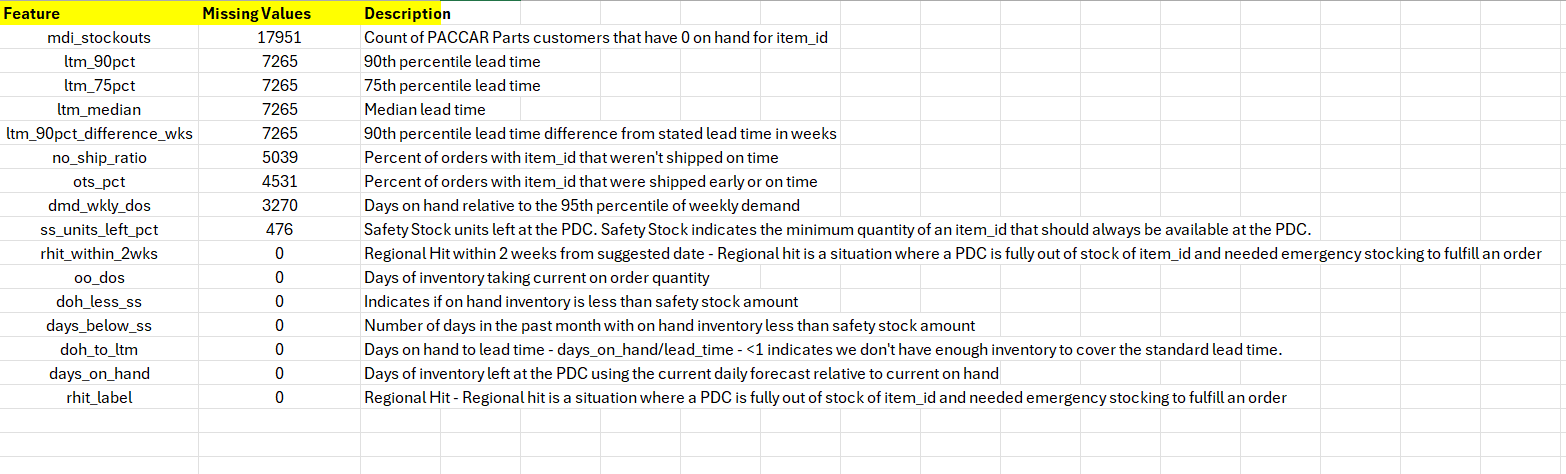

### Question: Should we keep rhit within 2 weeks, would it lead to data leakage?

#### 🔍 What is rhit_within_2wks?
It indicates whether there was a regional hit in the past 2 weeks from the suggestion date.

The target variable rhit_label is defined as a regional hit in the following lead time + 5 days.

#### ✅ Pros of Keeping rhit_within_2wks
Argument	Reason
Predictive Power	It has the highest correlation with the target (0.36) — strong signal.
Realistic Feature	If you're using this model in production daily, rhit_within_2wks is known at the time of prediction.
Captures Recency	Past short-term hits often signal unresolved inventory or supply chain issues.

#### ❌ Cons of Keeping rhit_within_2wks
Argument	Reason
Potential Data Leakage	If it's highly correlated with the same cause as future hits (e.g. same demand spike), it might leak information from the future.
Overfitting Risk	The model may over-rely on this single feature and underlearn broader patterns.
Not Actionable Alone	You can’t reduce future hits just by knowing they happened in the past 2 weeks.

#### 🧠 Recommendation
Keep it for baseline modeling and feature importance analysis.

Then:

Train a second model without it, and compare performance.

If performance is similar, prefer the simpler model without rhit_within_2wks (better generalization).

If performance drops significantly, it’s likely a valuable feature — and if it’s available at prediction time, it’s valid to keep.

In [10]:
## so we are keeping rhit within 2 weeks feature, and let's see later by comparing with and without



%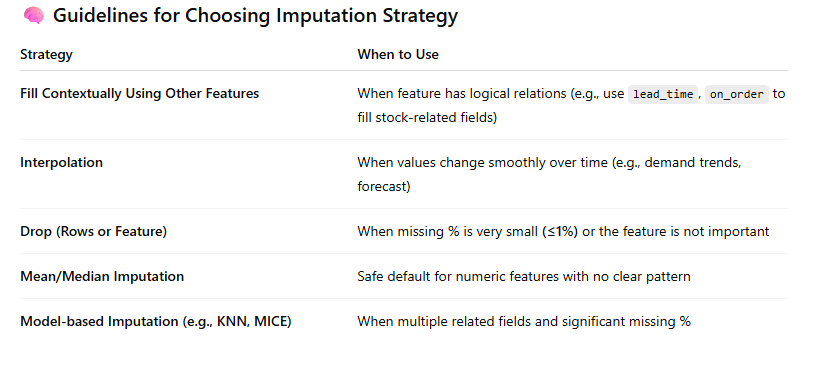

Now,

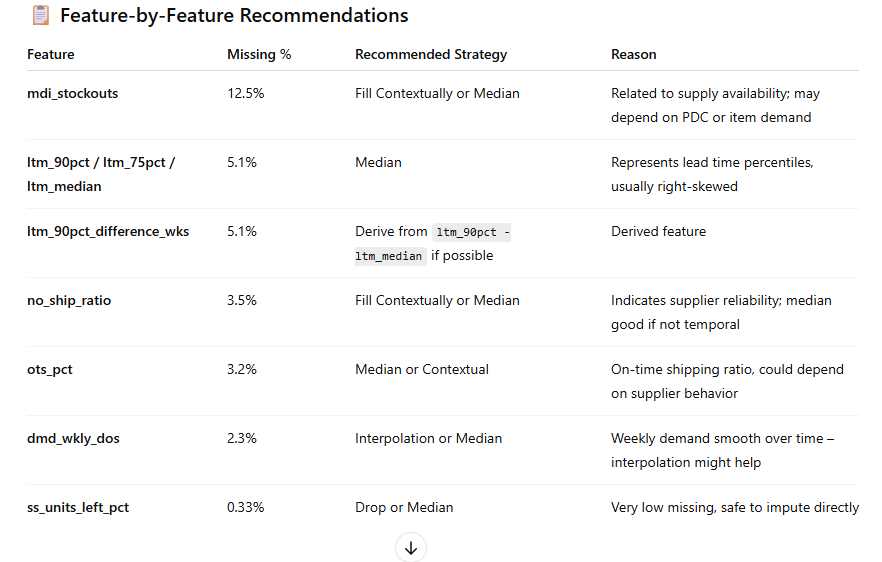

# Let's start filling one by one

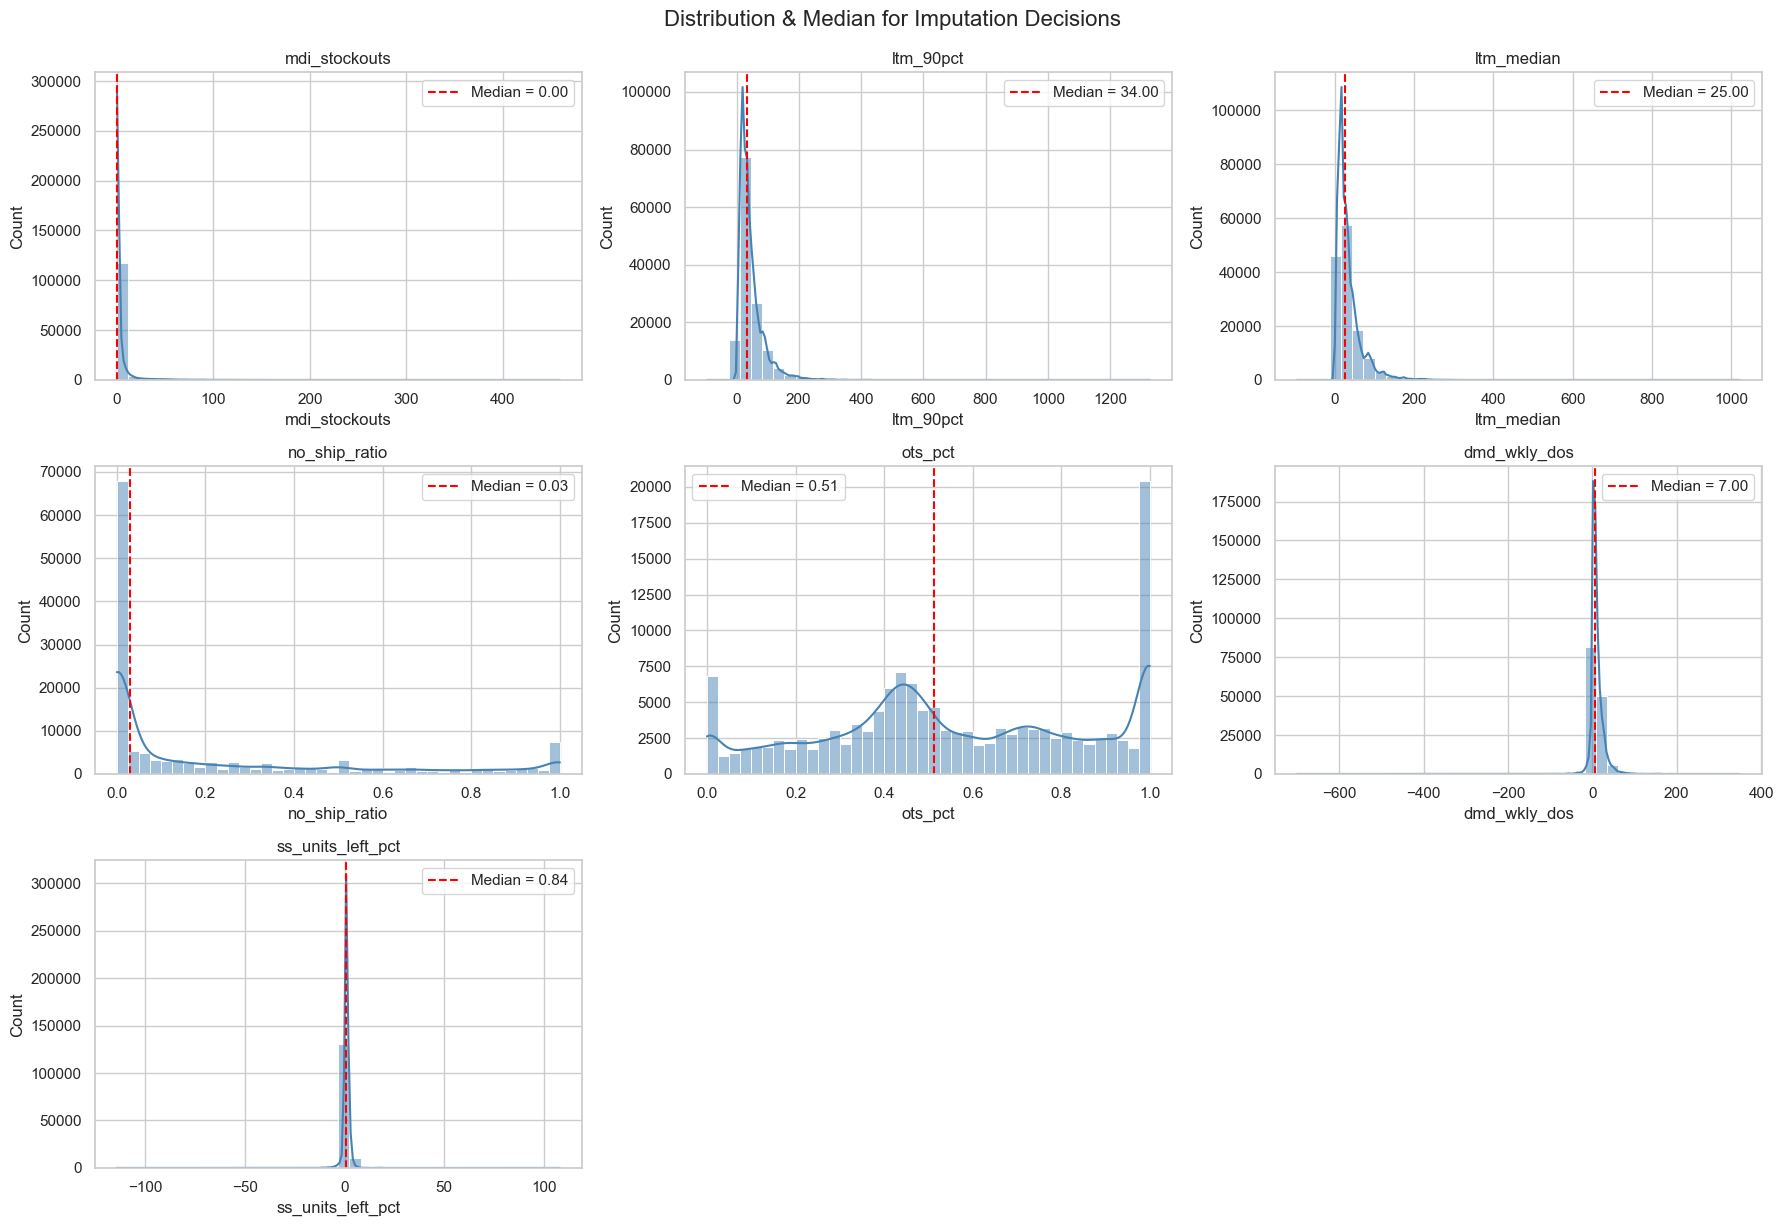

In [11]:
# Import missing again
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Visualize distributions & median for imputation support
features_to_plot = [
    'mdi_stockouts', 'ltm_90pct', 'ltm_median', 'no_ship_ratio',
    'ots_pct', 'dmd_wkly_dos', 'ss_units_left_pct'
]

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    sns.histplot(df_model[feature].dropna(), bins=40, kde=True, ax=axes[i], color='steelblue')
    median_val = df_model[feature].median()
    axes[i].axvline(median_val, color='red', linestyle='--', label=f'Median = {median_val:.2f}')
    axes[i].set_title(f'{feature}')
    axes[i].legend()

# Hide unused subplots
for j in range(len(features_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distribution & Median for Imputation Decisions", fontsize=16, y=1.02)
plt.show()


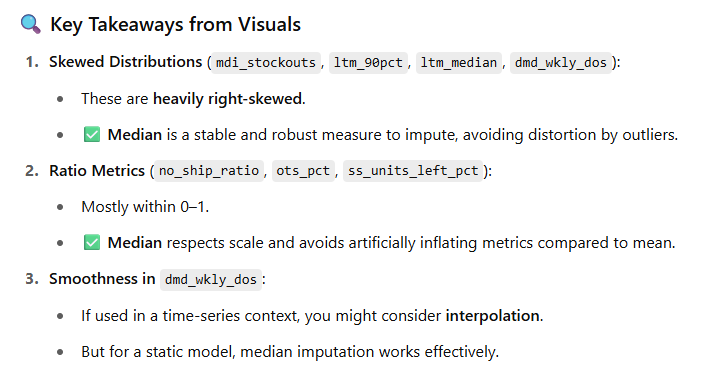

In [14]:
# Step-by-step imputation based on our plan
df_cleaned = df_model.copy()

# Impute with median
median_impute_cols = [
    'mdi_stockouts', 'ltm_90pct', 'ltm_75pct', 'ltm_median',
    'no_ship_ratio', 'ots_pct', 'dmd_wkly_dos', 'ss_units_left_pct'
]
for col in median_impute_cols:
    if col in df_cleaned.columns:
        df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)

# Derive ltm_90pct_difference_wks from imputed columns
df_cleaned['ltm_90pct_difference_wks'] = df_cleaned['ltm_90pct'] - df_cleaned['ltm_median']

# Sanity check - ensure no missing values
missing_post_impute = df_cleaned.isnull().sum()
#missing_post_impute = missing_post_impute[missing_post_impute > 0]

missing_post_impute

rhit_within_2wks            0
oo_dos                      0
doh_less_ss                 0
days_below_ss               0
no_ship_ratio               0
ltm_90pct                   0
ltm_75pct                   0
ltm_median                  0
ltm_90pct_difference_wks    0
mdi_stockouts               0
ots_pct                     0
ss_units_left_pct           0
dmd_wkly_dos                0
doh_to_ltm                  0
days_on_hand                0
rhit_label                  0
dtype: int64

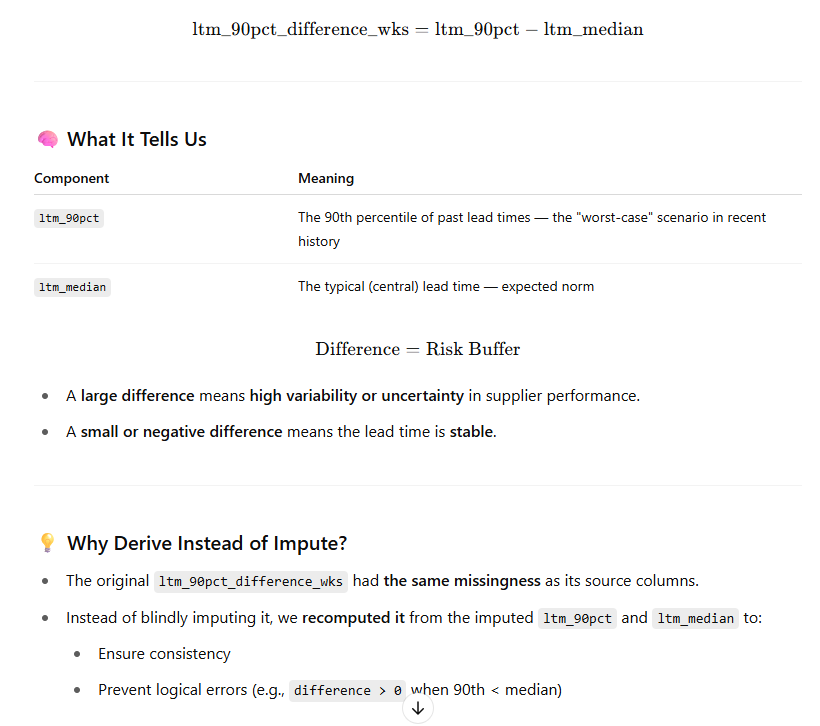

We need to understand what the selected variables mean in simple terms:

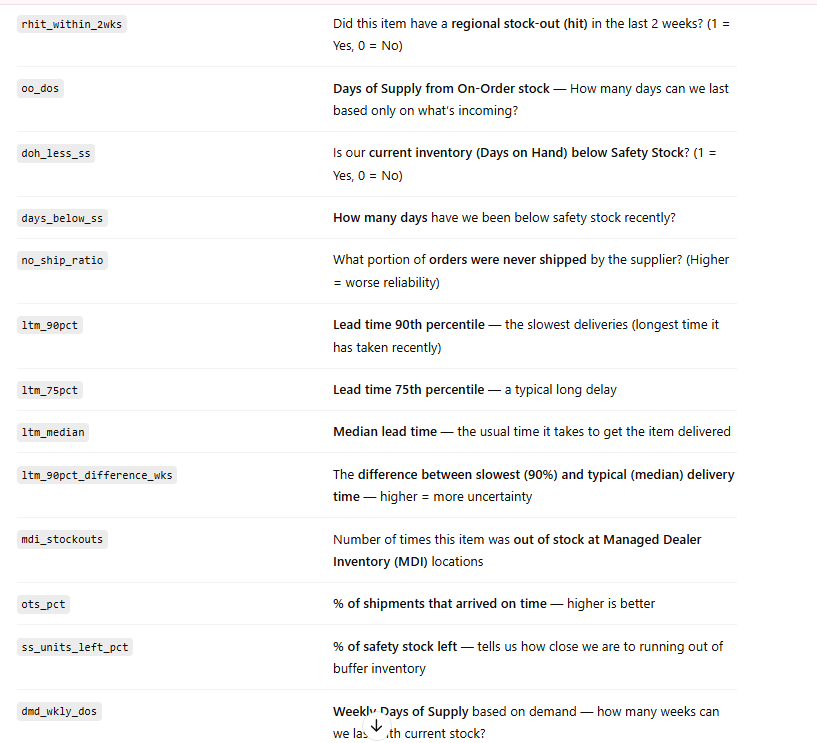

In [17]:
df_cleaned.to_csv("Paccar Cleaned Data - Selected_Features.csv")